In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('board_games 2.csv')
print("Dataset shape:", df.shape)
print("\nKey columns:")
print(df.columns.tolist())
print("\nMissing values in key columns:")
print(df[['average_rating', 'category', 'mechanic', 'min_players', 'max_players']].isnull().sum())

Dataset shape: (10532, 22)

Key columns:
['game_id', 'description', 'image', 'max_players', 'max_playtime', 'min_age', 'min_players', 'min_playtime', 'name', 'playing_time', 'thumbnail', 'year_published', 'artist', 'category', 'compilation', 'designer', 'expansion', 'family', 'mechanic', 'publisher', 'average_rating', 'users_rated']

Missing values in key columns:
average_rating      0
category           94
mechanic          950
min_players         0
max_players         0
dtype: int64


In [7]:
def process_multivalued_column(df, column_name, top_n=30):
    """
    Process comma-separated values into binary features
    Keep only top N most frequent values to avoid too many features
    """
    if column_name not in df.columns:
        print(f"Warning: {column_name} not found!")
        return pd.DataFrame(), []
    
    # Fill NaN with empty string
    df[column_name] = df[column_name].fillna('')
    
    # Split by comma and clean whitespace
    values_list = df[column_name].str.split(',').apply(
        lambda x: [i.strip() for i in x if i.strip()] if isinstance(x, list) else []
    )
    
    # Get frequency counts to select top N
    all_values = [item for sublist in values_list for item in sublist]
    value_counts = pd.Series(all_values).value_counts()
    top_values = value_counts.head(top_n).index.tolist()
    
    print(f"\n{column_name.upper()}:")
    print(f"  Total unique: {len(value_counts)}")
    print(f"  Using top {top_n}: {top_values[:10]}...")
    
    # Filter to only top N values
    filtered_list = values_list.apply(
        lambda x: [v for v in x if v in top_values]
    )
    
    # Create binary encoding
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(filtered_list)
    
    # Create DataFrame
    encoded_df = pd.DataFrame(
        encoded,
        columns=[f"{column_name}_{cat}" for cat in mlb.classes_],
        index=df.index
    )
    
    return encoded_df, mlb.classes_.tolist()

# Process categories and mechanics
categories_df, category_names = process_multivalued_column(df, 'category', top_n=30)
mechanics_df, mechanic_names = process_multivalued_column(df, 'mechanic', top_n=30)



CATEGORY:
  Total unique: 83
  Using top 30: ['Card Game', 'Wargame', 'Fantasy', 'Fighting', 'Economic', 'Science Fiction', 'Dice', 'Party Game', 'Abstract Strategy', "Children's Game"]...

MECHANIC:
  Total unique: 51
  Using top 30: ['Dice Rolling', 'Hand Management', 'Set Collection', 'Hex-and-Counter', 'Variable Player Powers', 'Tile Placement', 'Modular Board', 'Card Drafting', 'Area Control / Area Influence', 'Auction/Bidding']...


In [8]:
# Prepare numerical features
numerical_cols = [
    'min_players', 'max_players', 'min_age', 
    'min_playtime', 'max_playtime', 'playing_time',
    'year_published', 'users_rated'
]

# Keep only columns that exist
numerical_cols = [col for col in numerical_cols if col in df.columns]

numerical_df = df[numerical_cols].copy()

# Handle missing/invalid values
numerical_df = numerical_df.fillna(numerical_df.median())
numerical_df = numerical_df.replace([np.inf, -np.inf], np.nan).fillna(numerical_df.median())

# Create derived features
numerical_df['player_range'] = numerical_df['max_players'] - numerical_df['min_players']
numerical_df['playtime_range'] = numerical_df['max_playtime'] - numerical_df['min_playtime']
numerical_df['avg_players'] = (numerical_df['max_players'] + numerical_df['min_players']) / 2
numerical_df['player_flexibility'] = numerical_df['player_range'] / (numerical_df['avg_players'] + 1)

# Log transform highly skewed features
if 'users_rated' in numerical_df.columns:
    numerical_df['log_users_rated'] = np.log1p(numerical_df['users_rated'])

print("\nNumerical features created:")
print(numerical_df.columns.tolist())



Numerical features created:
['min_players', 'max_players', 'min_age', 'min_playtime', 'max_playtime', 'playing_time', 'year_published', 'users_rated', 'player_range', 'playtime_range', 'avg_players', 'player_flexibility', 'log_users_rated']


In [9]:
# IMPORTANT: We exclude average_rating from clustering features
# We want to cluster by game characteristics, then analyze ratings
features = pd.concat([numerical_df, categories_df, mechanics_df], axis=1)

# Remove any remaining NaN
features = features.fillna(0)

print(f"\nFinal feature matrix: {features.shape}")
print(f"Features per category:")
print(f"  Numerical: {len(numerical_df.columns)}")
print(f"  Categories: {len(categories_df.columns)}")
print(f"  Mechanics: {len(mechanics_df.columns)}")


Final feature matrix: (10532, 73)
Features per category:
  Numerical: 13
  Categories: 30
  Mechanics: 30


In [10]:
# Stardardize features so that each feature has mean=0 and std=1
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(
    features_scaled, 
    columns=features.columns, 
    index=features.index
)



Finding optimal number of clusters...


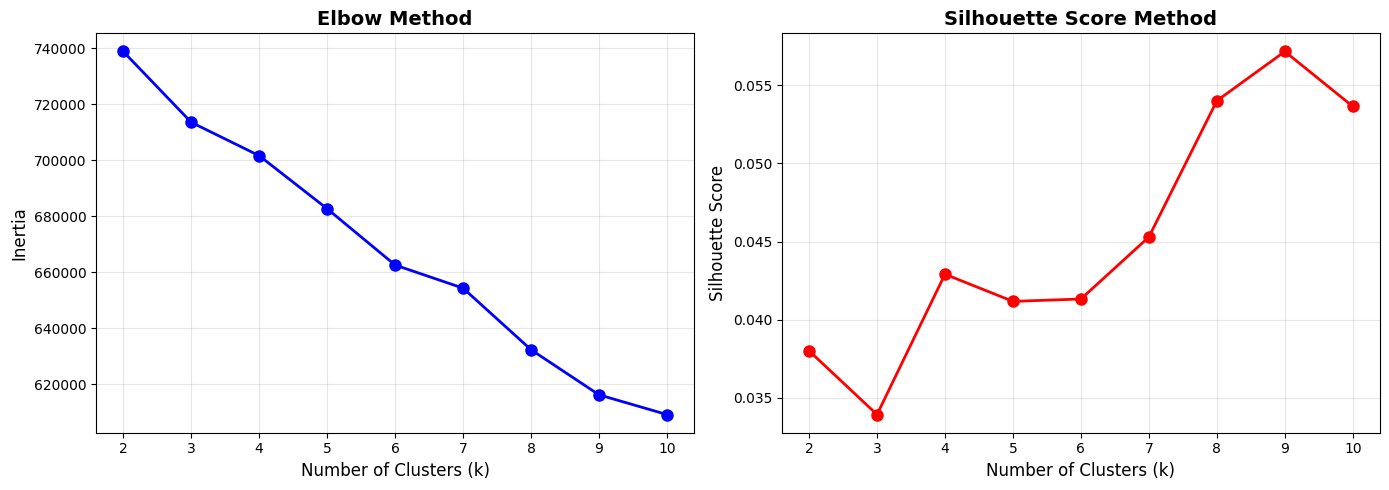


 Recommended k: 9 (highest silhouette score: 0.057)


In [12]:
#Find optimal number of clusters using Elbow Method and Silhouette Score
def find_optimal_clusters(data, max_k=10):
    """Elbow and Silhouette methods"""
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    
    print("\nFinding optimal number of clusters...")
    for k in K_range:
        print(f"  Testing k={k}...", end='\r')
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax1.set_ylabel('Inertia', fontsize=12)
    ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.set_title('Silhouette Score Method', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('optimal_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    best_k = K_range[np.argmax(silhouette_scores)]
    print(f"\n Recommended k: {best_k} (highest silhouette score: {max(silhouette_scores):.3f})")
    return best_k

optimal_k = find_optimal_clusters(features_scaled, max_k=10)


In [13]:
n_clusters = optimal_k  # or manually set, e.g., n_clusters = 5
print(f"\nPerforming K-Means clustering with {n_clusters} clusters...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
df['cluster'] = kmeans.fit_predict(features_scaled)

print("\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())



Performing K-Means clustering with 9 clusters...

Cluster distribution:
cluster
0    1333
1    1149
2    1748
3    3669
4    1563
5     348
6     718
7       3
8       1
Name: count, dtype: int64


In [16]:
#Analyaze average ratings by cluster
print(f"\n{'='*70}")
print("CLUSTER ANALYSIS: AVERAGE RATINGS BY CLUSTER")
print(f"{'='*70}")

# Calculate statistics
cluster_stats = df.groupby('cluster')['average_rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max')
]).round(3)

print("\n" + cluster_stats.to_string())

# Statistical significance testing
overall_mean = df['average_rating'].mean()
print(f"\nOverall mean rating: {overall_mean:.3f}")

print("\n" + "="*70)
print("STATISTICAL SIGNIFICANCE (vs overall mean):")
print("="*70)

for cluster_id in sorted(df['cluster'].unique()):
    cluster_ratings = df[df['cluster'] == cluster_id]['average_rating']
    diff = cluster_ratings.mean() - overall_mean
    
    # T-test
    t_stat, p_value = stats.ttest_1samp(cluster_ratings.dropna(), overall_mean)
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    
    if diff > 0:
        print(f"Cluster {cluster_id}: +{diff:.3f} {significance} (p={p_value:.4f})")
    else:
        print(f"Cluster {cluster_id}: {diff:.3f} {significance} (p={p_value:.4f})")

# Identify high-rating clusters
mean_ratings = cluster_stats['mean']
threshold = mean_ratings.quantile(0.75)
high_rating_clusters = mean_ratings[mean_ratings >= threshold].index.tolist()

print(f"\n HIGH-RATING CLUSTERS (top 25%): {high_rating_clusters}")
print(f"   Threshold: {threshold:.3f}")



CLUSTER ANALYSIS: AVERAGE RATINGS BY CLUSTER

         count   mean  median    std    min    max
cluster                                           
0         1333  6.577   6.638  0.819  1.846  8.849
1         1149  6.717   6.767  0.830  3.196  9.004
2         1748  6.763   6.798  0.793  3.372  8.846
3         3669  6.155   6.179  0.786  1.970  8.528
4         1563  5.912   5.994  0.784  1.384  8.271
5          348  7.031   7.018  0.622  4.587  8.477
6          718  6.261   6.275  0.696  3.961  8.323
7            3  6.482   6.498  0.339  6.135  6.813
8            1  5.629   5.629    NaN  5.629  5.629

Overall mean rating: 6.371

STATISTICAL SIGNIFICANCE (vs overall mean):
Cluster 0: +0.206 *** (p=0.0000)
Cluster 1: +0.346 *** (p=0.0000)
Cluster 2: +0.392 *** (p=0.0000)
Cluster 3: -0.216 *** (p=0.0000)
Cluster 4: -0.459 *** (p=0.0000)
Cluster 5: +0.660 *** (p=0.0000)
Cluster 6: -0.110 *** (p=0.0000)
Cluster 7: +0.111  (p=0.6269)
Cluster 8: -0.742  (p=nan)

 HIGH-RATING CLUSTERS (top 25%

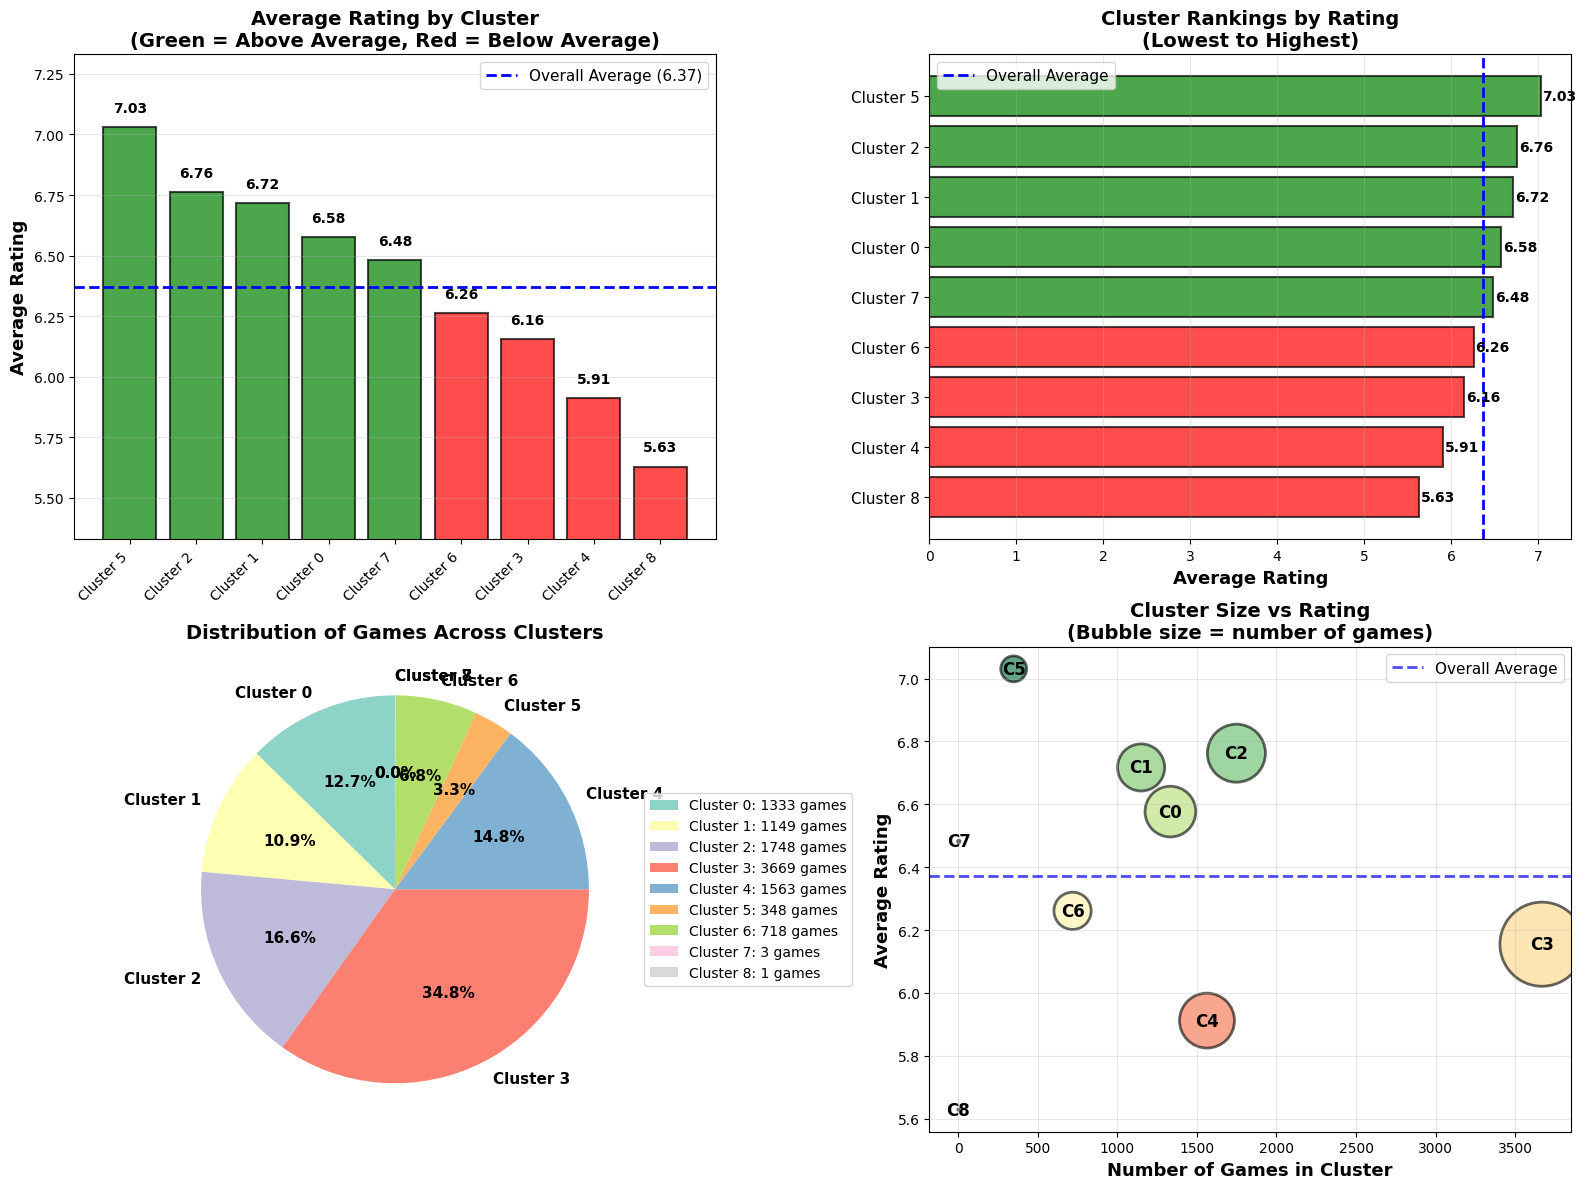

In [ ]:
#Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

cluster_means = df.groupby('cluster')['average_rating'].mean().sort_values(ascending=False)
cluster_counts = df.groupby('cluster').size()

# 1. SIMPLE BAR CHART - Average Rating by Cluster (sorted)
ax1 = axes[0, 0]
colors = ['green' if x >= overall_mean else 'red' for x in cluster_means.values]
bars = ax1.bar(range(len(cluster_means)), cluster_means.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(overall_mean, color='blue', linestyle='--', linewidth=2, label=f'Overall Average ({overall_mean:.2f})')
ax1.set_xticks(range(len(cluster_means)))
ax1.set_xticklabels([f'Cluster {i}' for i in cluster_means.index], rotation=45, ha='right')
ax1.set_ylabel('Average Rating', fontsize=13, fontweight='bold')
ax1.set_title('Average Rating by Cluster\n(Green = Above Average, Red = Below Average)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([cluster_means.min() - 0.3, cluster_means.max() + 0.3])

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, cluster_means.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. HORIZONTAL BAR - Easier to read cluster names
ax2 = axes[0, 1]
sorted_clusters = cluster_means.sort_values()
colors2 = ['green' if x >= overall_mean else 'red' for x in sorted_clusters.values]
bars2 = ax2.barh(range(len(sorted_clusters)), sorted_clusters.values, color=colors2, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axvline(overall_mean, color='blue', linestyle='--', linewidth=2, label=f'Overall Average')
ax2.set_yticks(range(len(sorted_clusters)))
ax2.set_yticklabels([f'Cluster {i}' for i in sorted_clusters.index], fontsize=11)
ax2.set_xlabel('Average Rating', fontsize=13, fontweight='bold')
ax2.set_title('Cluster Rankings by Rating\n(Lowest to Highest)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, sorted_clusters.values)):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
            va='center', fontsize=10, fontweight='bold')

# 3. PIE CHART - Distribution of games across clusters
ax3 = axes[1, 0]
cluster_sizes = cluster_counts.sort_index()
colors3 = plt.cm.Set3(range(len(cluster_sizes)))
wedges, texts, autotexts = ax3.pie(cluster_sizes.values, labels=[f'Cluster {i}' for i in cluster_sizes.index],
                                    autopct='%1.1f%%', colors=colors3, startangle=90,
                                    textprops={'fontsize': 11, 'fontweight': 'bold'})
ax3.set_title('Distribution of Games Across Clusters', fontsize=14, fontweight='bold')

# Add count in legend
legend_labels = [f'Cluster {i}: {count} games' for i, count in zip(cluster_sizes.index, cluster_sizes.values)]
ax3.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)

# 4. SCATTER - Cluster Size vs Rating (bubble chart style)
ax4 = axes[1, 1]
cluster_means_sorted = df.groupby('cluster')['average_rating'].mean()
cluster_sizes_sorted = cluster_counts

# Color based on rating
colors4 = plt.cm.RdYlGn((cluster_means_sorted.values - cluster_means_sorted.min()) / 
                        (cluster_means_sorted.max() - cluster_means_sorted.min()))

scatter = ax4.scatter(cluster_sizes_sorted.values, cluster_means_sorted.values, 
                    s=cluster_sizes_sorted.values, alpha=0.6, c=colors4, edgecolors='black', linewidth=2)

# Add cluster labels
for i, (size, rating) in enumerate(zip(cluster_sizes_sorted.values, cluster_means_sorted.values)):
    ax4.annotate(f'C{i}', (size, rating), fontsize=12, fontweight='bold', ha='center', va='center')

ax4.axhline(overall_mean, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Overall Average')
ax4.set_xlabel('Number of Games in Cluster', fontsize=13, fontweight='bold')
ax4.set_ylabel('Average Rating', fontsize=13, fontweight='bold')
ax4.set_title('Cluster Size vs Rating\n(Bubble size = number of games)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ratings_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
print(f"\n{'='*70}")
print("DETAILED CLUSTER PROFILING")
print(f"{'='*70}")

for cluster_id in sorted(df['cluster'].unique()):
    cluster_games = df[df['cluster'] == cluster_id]
    cluster_indices = cluster_games.index
    
    print(f"\n{'*'*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'*'*70}")
    print(f"Size: {len(cluster_games)} games ({len(cluster_games)/len(df)*100:.1f}%)")
    print(f"Mean Rating: {cluster_games['average_rating'].mean():.3f}")
    print(f"Rating Range: {cluster_games['average_rating'].min():.2f} - {cluster_games['average_rating'].max():.2f}")
    
    # Numerical characteristics
    print("\n NUMERICAL CHARACTERISTICS:")
    num_cols_display = ['min_players', 'max_players', 'min_age', 'playing_time', 
                        'year_published', 'users_rated']
    for col in num_cols_display:
        if col in cluster_games.columns:
            mean_val = cluster_games[col].mean()
            median_val = cluster_games[col].median()
            print(f"  {col}: mean={mean_val:.1f}, median={median_val:.1f}")
    
    # Top categories
    print("\n TOP 5 CATEGORIES:")
    cat_cols = [col for col in categories_df.columns]
    if cat_cols:
        cat_sums = categories_df.loc[cluster_indices, cat_cols].sum()
        top_cats = cat_sums.nlargest(5)
        for cat, count in top_cats.items():
            cat_name = cat.replace('category_', '')
            pct = (count / len(cluster_games)) * 100
            print(f"  • {cat_name}: {int(count)} games ({pct:.1f}%)")
    
    # Top mechanics
    print("\n  TOP 5 MECHANICS:")
    mech_cols = [col for col in mechanics_df.columns]
    if mech_cols:
        mech_sums = mechanics_df.loc[cluster_indices, mech_cols].sum()
        top_mechs = mech_sums.nlargest(5)
        for mech, count in top_mechs.items():
            mech_name = mech.replace('mechanic_', '')
            pct = (count / len(cluster_games)) * 100
            print(f"  • {mech_name}: {int(count)} games ({pct:.1f}%)")
    
    # Top rated games in cluster
    print("\n TOP 5 HIGHEST-RATED GAMES:")
    top_games = cluster_games.nlargest(5, 'average_rating')[['name', 'average_rating', 'year_published']]
    for idx, row in top_games.iterrows():
        print(f"  • {row['name']} ({int(row['year_published'])}) - Rating: {row['average_rating']:.2f}")



DETAILED CLUSTER PROFILING

**********************************************************************
CLUSTER 0
**********************************************************************
Size: 1333 games (12.7%)
Mean Rating: 6.577
Rating Range: 1.85 - 8.85

 NUMERICAL CHARACTERISTICS:
  min_players: mean=2.2, median=2.0
  max_players: mean=5.1, median=5.0
  min_age: mean=10.7, median=10.0
  playing_time: mean=98.4, median=75.0
  year_published: mean=2003.8, median=2007.0
  users_rated: mean=1895.3, median=412.0

 TOP 5 CATEGORIES:
  • Economic: 673 games (50.5%)
  • Negotiation: 277 games (20.8%)
  • Political: 191 games (14.3%)
  • City Building: 186 games (14.0%)
  • Medieval: 139 games (10.4%)

  TOP 5 MECHANICS:
  • Auction/Bidding: 411 games (30.8%)
  • Area Control / Area Influence: 347 games (26.0%)
  • Set Collection: 329 games (24.7%)
  • Hand Management: 282 games (21.2%)
  • Tile Placement: 275 games (20.6%)

 TOP 5 HIGHEST-RATED GAMES:
  • Terra Mystica: Big Box (2015) - Rating: 